In [1]:
import pandas as pd
import re
import numpy as np

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

from wordcloud import WordCloud

In [2]:
data = pd.read_csv("data.csv")

In [3]:
data.columns = map(str.lower, data.columns)

data.head()

,song,artist names,hot100 ranking year,hot100 rank,lyrics
0,Prisoner of Love - Remastered - 1992,['perry como'],1946,1,"['someone', 'that', 'i', 'belong', 'to', 'does..."
1,To Each His Own,['eddy howard'],1946,2,"['a', 'rose', 'must', 'remain', 'with', 'the',..."
2,The Gypsy,['the ink spots'],1946,3,"['in', 'a', 'quaint', 'caravan', 'theres', 'a'..."
3,Five Minutes More,['frank sinatra'],1946,4,"['dear', 'this', 'evening', 'seemed', 'to', 'g..."
4,Rumors Are Flying,['frankie carle'],1946,5,"['rumors', 'are', 'flying', 'that', 'youve', '..."


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6879 entries, 0 to 6878
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   song                 6879 non-null   object
 1   artist names         6879 non-null   object
 2   hot100 ranking year  6879 non-null   int64 
 3   hot100 rank          6879 non-null   int64 
 4   lyrics               6032 non-null   object
dtypes: int64(2), object(3)
memory usage: 268.8+ KB


In [5]:
data[data['lyrics'].isna()]

,song,artist names,hot100 ranking year,hot100 rank,lyrics
5,Oh! What It Seemed to Be,['frankie carle his piano orchestra'],1946,6,NaN
13,To Each His Own,['freddy martin his orchestra'],1946,14,NaN
14,Ole Buttermilk Sky,['kay kyser his orchestra'],1946,15,NaN
17,The Old Lamplighter,['sammy kaye his orchestra'],1946,18,NaN
20,"Jocelyn, Op. 100: Berceuse (Arr. For vocal, vi...","['benjamin godard', 'bing crosby', 'jascha hei...",1946,20,NaN
...,...,...,...,...,...
6706,Dakiti (Originally Performed by Bad Bunny & Jh...,['backing business'],2021,28,NaN
6725,Wants & Needs,['homixide gang'],2021,47,NaN
6798,Yo Me Porto Bonito,['bad bunn'],2022,20,NaN
6811,Jimmy Cooks - Lofi Cover,"['covers unplugged', 'wild issues']",2022,33,NaN


In [6]:
data = data.dropna(subset=['lyrics'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6032 entries, 0 to 6878
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   song                 6032 non-null   object
 1   artist names         6032 non-null   object
 2   hot100 ranking year  6032 non-null   int64 
 3   hot100 rank          6032 non-null   int64 
 4   lyrics               6032 non-null   object
dtypes: int64(2), object(3)
memory usage: 282.8+ KB


In [7]:
data = data.rename(columns={'hot100 ranking year': 'year'})
data = data.rename(columns={'hot100 rank': 'rank'})
data = data.rename(columns={'artist names': 'artist'})
data['decade']= (data['year'].astype(int) // 10) *10

In [8]:
data.head()

,song,artist,year,rank,lyrics,decade
0,Prisoner of Love - Remastered - 1992,['perry como'],1946,1,"['someone', 'that', 'i', 'belong', 'to', 'does...",1940
1,To Each His Own,['eddy howard'],1946,2,"['a', 'rose', 'must', 'remain', 'with', 'the',...",1940
2,The Gypsy,['the ink spots'],1946,3,"['in', 'a', 'quaint', 'caravan', 'theres', 'a'...",1940
3,Five Minutes More,['frank sinatra'],1946,4,"['dear', 'this', 'evening', 'seemed', 'to', 'g...",1940
4,Rumors Are Flying,['frankie carle'],1946,5,"['rumors', 'are', 'flying', 'that', 'youve', '...",1940


In [9]:
decadal_lyrics = data.groupby('decade')['lyrics'].apply(lambda x: " ".join(x)).reset_index()

In [10]:
# Preprocessing
def preprocess_text(text):
    # remove special character and digit|
    text = re.sub(r'\W', " ", text)
    text = re.sub(r'\d+',"", text)
    # convert to lowercase
    text = text.lower()
    return text


In [42]:
#tokenization and stopword removal
stop_words = set(stopwords.words('english'))

new = {"dont","im","youre","lil","ill","bout","pull","yeah","gonna","aint","ive", "youll","wont","woo","yay","like","got","nah","ah","get","na","like",'que', 'pero', 'con', 'por', 'est', 'noche', 'hace', 'tiempo', 'esta', 'todo', 'una', 'voa', 'dime', 'hoy', 'estoy', 'vamo', 'quieres', 'mami', 'ests', 'eres',"ooh" }
stop_words.update(new)
words_and_phrases = {
    'x', 'y', 'your',"wanna","wan na", "wan","say", "look","theres", "hey","hey hey","woa","ayy ay","ayy","ay", "well","let","tell","see","thats","want","come","need","nothin",'yours', 'yourself', 'yourselves',"know","cause", 'you', 'yond', 'yonder', 'yon', 'ye', 'yet', 'z', 'zillion', 'j', 'u', 'umpteen', 'usually', 'us', 'username', 'uponed', 'upons', 'uponing', 'upon', 'ups', 'upping', 'upped', 'up', 'unto', 'until', 'unless', 'unlike', 'unliker', 'unlikest', 'under', 'underneath', 'use', 'used', 'usedest', 'r', 'rath', 'rather', 'rathest', 'rathe', 're', 'relate', 'related', 'relatively', 'regarding', 'really', 'res', 'respecting', 'respectively', 'q', 'quite', 'que', 'qua', 'n', 'neither', 'neaths', 'neath', 'nethe', 'nethermost', 'necessary', 'necessariest', 'necessarier', 'never', 'nevertheless', 'nigh', 'nighest', 'nigher', 'nine', 'noone', 'nobody', 'nobodies', 'nowhere', 'nowheres', 'no', 'noes', 'nor', 'nos', 'no-one', 'none', 'not', 'notwithstanding', 'nothings', 'nothing', 'nathless', 'natheless', 't', 'ten', 'tills', 'till', 'tilled', 'tilling', 'to', 'towards', 'toward', 'towardest', 'towarder', 'together', 'too', 'thy', 'thyself', 'thus', 'than', 'that', 'those', 'thou', 'though', 'thous', 'thouses', 'thoroughest', 'thorougher', 'thorough', 'thoroughly', 'thru', 'thruer', 'thruest', 'thro', 'through', 'throughout', 'throughest', 'througher', 'thine', 'this', 'thises', 'they', 'thee', 'the', 'then', 'thence', 'thenest', 'thener', 'them', 'themselves', 'these', 'therer', 'there', 'thereby', 'therest', 'thereafter', 'therein', 'thereupon', 'therefore', 'their', 'theirs', 'thing', 'things', 'three', 'two', 'o', 'oh', 'owt', 'owning', 'owned', 'own', 'owns', 'others', 'other', 'otherwise', 'otherwisest', 'otherwiser', 'of', 'often', 'oftener', 'oftenest', 'off', 'offs', 'offest', 'one', 'ought', 'oughts', 'our', 'ours', 'ourselves', 'ourself', 'out', 'outest', 'outed', 'outwith', 'outs', 'outside', 'over', 'overallest', 'overaller', 'overalls', 'overall', 'overs', 'or', 'orer', 'orest', 'on', 'oneself', 'onest', 'ons', 'onto', 'a', 'atween', 'at', 'athwart', 'atop', 'afore', 'afterward', 'afterwards', 'after', 'afterest', 'afterer', 'ain', 'an', 'any', 'anything', 'anybody', 'anyone', 'anyhow', 'anywhere', 'anent', 'anear', 'and', 'andor', 'another', 'around', 'ares', 'are', 'aest', 'aer', 'against', 'again', 'accordingly', 'abaft', 'abafter', 'abaftest', 'abovest', 'above', 'abover', 'abouter', 'aboutest', 'about', 'aid', 'amidst', 'amid', 'among', 'amongst', 'apartest', 'aparter', 'apart', 'appeared', 'appears', 'appear', 'appearing', 'appropriating', 'appropriate', 'appropriatest', 'appropriates', 'appropriater', 'appropriated', 'already', 'always', 'also', 'along', 'alongside', 'although', 'almost', 'all', 'allest', 'aller', 'allyou', 'alls', 'albeit', 'awfully', 'as', 'aside', 'asides', 'aslant', 'ases', 'astrider', 'astride', 'astridest', 'astraddlest', 'astraddler', 'astraddle', 'availablest', 'availabler', 'available', 'aughts', 'aught', 'vs', 'v', 'variousest', 'variouser', 'various', 'via', 'vis-a-vis', 'vis-a-viser', 'vis-a-visest', 'viz', 'very', 'veriest', 'verier', 'versus', 'n', 'neither', 'neaths', 'neath', 'nethe', 'nethermost', 'necessary', 'necessariest', 'necessarier', 'never', 'nevertheless', 'nigh', 'nighest', 'nigher', 'nine', 'noone', 'nobody', 'nobodies', 'nowhere', 'nowheres', 'no', 'noes', 'nor', 'nos', 'no-one', 'none', 'not', 'notwithstanding', 'nothings', 'nothing', 'nathless', 'natheless', 't', 'ten', 'tills', 'till', 'tilled', 'tilling', 'to', 'towards', 'toward', 'towardest', 'towarder', 'together', 'too', 'thy', 'thyself', 'thus', 'than', 'that', 'those', 'thou', 'though', 'thous', 'thouses', 'thoroughest', 'thorougher', 'thorough', 'thoroughly', 'thru', 'thruer', 'thruest', 'thro', 'through', 'throughout', 'throughest', 'througher', 'thine', 'this', 'thises', 'they', 'thee', 'the', 'then', 'thence', 'thenest', 'thener', 'them', 'themselves', 'these', 'therer', 'there', 'thereby', 'therest', 'thereafter', 'therein', 'thereupon', 'therefore', 'their', 'theirs', 'thing', 'things', 'three', 'two', 'o', 'oh', 'owt', 'owning', 'owned', 'own', 'owns', 'others', 'other', 'otherwise', 'otherwisest', 'otherwiser', 'of', 'often', 'oftener', 'oftenest', 'off', 'offs', 'offest', 'one', 'ought', 'oughts', 'our', 'ours', 'ourselves', 'ourself', 'out', 'outest', 'outed', 'outwith', 'outs', 'outside', 'over', 'overallest', 'overaller', 'overalls', 'overall', 'overs', 'or', 'orer', 'orest', 'on', 'oneself', 'onest', 'ons', 'onto', 'a', 'atween', 'at', 'athwart', 'atop', 'afore', 'afterward', 'afterwards', 'after', 'afterest', 'afterer', 'ain', 'an', 'any', 'anything', 'anybody', 'anyone', 'anyhow', 'anywhere', 'anent', 'anear', 'and', 'andor', 'another', 'around', 'ares', 'are', 'aest', 'aer', 'against', 'again', 'accordingly', 'abaft', 'abafter', 'abaftest', 'abovest', 'above', 'abover', 'abouter', 'aboutest', 'about', 'aid', 'amidst', 'amid', 'among', 'amongst', 'apartest', 'aparter', 'apart', 'appeared', 'appears', 'appear', 'appearing', 'appropriating', 'appropriate', 'appropriatest', 'appropriates', 'appropriater', 'appropriated', 'already', 'always', 'also', 'along', 'alongside', 'although', 'almost', 'all', 'allest', 'aller', 'allyou', 'alls', 'albeit', 'awfully', 'as', 'aside', 'asides', 'aslant', 'ases', 'astrider', 'astride', 'astridest', 'astraddlest', 'astraddler', 'astraddle', 'availablest', 'availabler', 'available', 'aughts', 'aught', 'vs', 'v', 'variousest', 'variouser', 'various', 'via', 'vis-a-vis', 'vis-a-viser', 'vis-a-visest', 'viz', 'very', 'veriest', 'verier', 'versus', 'v', 'v', 'variousest', 'variouser', 'various', 'via', 'vis-a-vis', 'vis-a-viser', 'vis-a-visest', 'viz', 'very', 'veriest', 'verier', 'versus', 'k', 'g', 'go', 'gone', 'good', 'got', 'gotta', 'gotten', 'get', 'gets', 'getting', 'b', 'by', 'byandby', 'by-and-by', 'bist', 'both', 'but', 'buts', 'be', 'beyond', 'because', 'became', 'becomes', 'become', 'becoming', 'becomings', 'becominger', 'becomingest', 'behind', 'behinds', 'before', 'beforehand', 'beforehandest', 'beforehander', 'bettered', 'betters', 'better', 'bettering', 'betwixt', 'between', 'beneath', 'been', 'below', 'besides', 'beside', 'm', 'my', 'myself', 'mucher', 'muchest', 'much', 'must', 'musts', 'musths', 'musth', 'main', 'make', 'mayest', 'many', 'mauger', 'maugre', 'me', 'meanwhiles', 'meanwhile', 'mostly', 'most', 'moreover', 'more', 'might', 'mights', 'midst', 'midsts', 'h', 'huh', 'humph', 'he', 'hers', 'herself', 'her', 'hereby', 'herein', 'hereafters', 'hereafter', 'hereupon', 'hence', 'hadst', 'had', 'having', 'haves', 'have', 'has', 'hast', 'hardly', 'hae', 'hath', 'him', 'himself', 'hither', 'hitherest', 'hitherer', 'his', 'how-do-you-do', 'however', 'how', 'howbeit', 'howdoyoudo', 'hoos', 'hoo', 'w', 'woulded', 'woulding', 'would', 'woulds', 'was', 'wast', 'we', 'wert', 'were', 'with', 'withal', 'without', 'within', 'why', 'what', 'whatever', 'whateverer', 'whateverest', 'whatsoeverer', 'whatsoeverest', 'whatsoever', 'whence', 'whencesoever', 'whenever', 'whensoever', 'when', 'whenas', 'whether', 'wheen', 'whereto', 'whereupon', 'wherever', 'whereon', 'whereof', 'where', 'whereby', 'wherewithal', 'wherewith', 'whereinto', 'wherein', 'whereafter', 'whereas', 'wheresoever', 'wherefrom', 'which', 'whichever', 'whichsoever', 'whilst', 'while', 'whiles', 'whithersoever', 'whither', 'whoever', 'whosoever', 'whoso', 'whose', 'whomever', 's', 'syne', 'syn', 'shalling', 'shall', 'shalled', 'shalls', 'shoulding', 'should', 'shoulded', 'shoulds', 'she', 'sayyid', 'sayid', 'said', 'saider', 'saidest', 'same', 'samest', 'sames', 'samer', 'saved', 'sans', 'sanses', 'sanserifs', 'sanserif', 'so', 'soer', 'soest', 'sobeit', 'someone', 'somebody', 'somehow', 'some', 'somewhere', 'somewhat', 'something', 'sometimest', 'sometimes', 'sometimer', 'sometime', 'several', 'severaler', 'severalest', 'serious', 'seriousest', 'seriouser', 'senza', 'send', 'sent', 'seem', 'seems', 'seemed', 'seemingest', 'seeminger', 'seemings', 'seven', 'summat', 'sups', 'sup', 'supping', 'supped', 'such', 'since', 'sine', 'sines', 'sith', 'six', 'stop', 'stopped', 'p', 'plaintiff', 'plenty', 'plenties', 'please', 'pleased', 'pleases', 'per', 'perhaps', 'particulars', 'particularly', 'particular', 'particularest', 'particularer', 'pro', 'providing', 'provides', 'provided', 'provide', 'probably', 'l', 'layabout', 'layabouts', 'latter', 'latterest', 'latterer', 'latterly', 'latters', 'lots', 'lotting', 'lotted', 'lot', 'lest', 'less', 'ie', 'ifs', 'if', 'i', 'info', 'information', 'itself', 'its', 'it', 'is', 'idem', 'idemer', 'idemest', 'immediate', 'immediately', 'immediatest', 'immediater', 'in', 'inwards', 'inwardest', 'inwarder', 'inward', 'inasmuch', 'into', 'instead', 'insofar', 'indicates', 'indicated', 'indicate', 'indicating', 'indeed', 'inc', 'f', 'fact', 'facts', 'fs', 'figupon', 'figupons', 'figuponing', 'figuponed', 'few', 'fewer', 'fewest', 'frae', 'from', 'failing', 'failings', 'five', 'furthers', 'furtherer', 'furthered', 'furtherest', 'further', 'furthering', 'furthermore', 'fourscore', 'followthrough', 'for', 'forwhy', 'fornenst', 'formerly', 'former', 'formerer', 'formerest', 'formers', 'forbye', 'forby', 'fore', 'forever', 'forer', 'fores', 'four', 'd', 'ddays', 'dday', 'do', 'doing', 'doings', 'doe', 'does', 'doth', 'downwarder', 'downwardest', 'downward', 'downwards', 'downs', 'done', 'doner', 'dones', 'donest', 'dos', 'dost', 'did', 'differentest', 'differenter', 'different', 'describing', 'describe', 'describes', 'described', 'despiting', 'despites', 'despited', 'despite', 'during', 'c', 'cum', 'circa', 'chez', 'cer', 'certain', 'certainest', 'certainer', 'cest', 'canst', 'cannot', 'cant', 'cants', 'canting', 'cantest', 'canted', 'co', 'could', 'couldst', 'comeon', 'comeons', 'come-ons', 'come-on', 'concerning', 'concerninger', 'concerningest', 'consequently', 'considering', 'e', 'eg', 'eight', 'either', 'even', 'evens', 'evenser', 'evensest', 'evened', 'evenest', 'ever', 'everyone', 'everything', 'everybody', 'everywhere', 'every', 'ere', 'each', 'et', 'etc', 'elsewhere', 'else', 'ex', 'excepted', 'excepts', 'except', 'excepting', 'exes', 'enough'
}

stop_words.update(words_and_phrases)
def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return ' '.join(words)


def tokenize(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return tokens



In [43]:
# Applying preprocessing and stopword removal
decadal_lyrics["cleaned"]= decadal_lyrics['lyrics'].apply(preprocess_text)
decadal_lyrics['cleaned']= decadal_lyrics['cleaned'].apply(remove_stopwords)
decadal_lyrics['tokenized'] = decadal_lyrics['cleaned'].apply(word_tokenize)
decadal_lyrics['processed'] = decadal_lyrics['tokenized'].apply(lambda x: " ".join(x))

#tokenize and process lyrics

decadal_lyrics.head()

,decade,lyrics,cleaned,tokenized,processed,cluster
0,1940,"['someone', 'that', 'i', 'belong', 'to', 'does...",belong doesnt belong faithful knows wonder wro...,"[belong, doesnt, belong, faithful, knows, wond...",belong doesnt belong faithful knows wonder wro...,2
1,1950,"['irene', 'goodnight', 'irene', 'goodnight', '...",irene goodnight irene goodnight goodnight iren...,"[irene, goodnight, irene, goodnight, goodnight...",irene goodnight irene goodnight goodnight iren...,3
2,1960,"['put', 'your', 'sweet', 'lips', 'a', 'little'...",put sweet lips little closer phone lets preten...,"[put, sweet, lips, little, closer, phone, lets...",put sweet lips little closer phone lets preten...,0
3,1970,"['when', 'youre', 'weary', 'feeling', 'small',...",weary feeling small tears eyes dry side times ...,"[weary, feeling, small, tears, eyes, dry, side...",weary feeling small tears eyes dry side times ...,0
4,1980,"['color', 'me', 'your', 'color', 'baby', 'colo...",color color baby color car color color darling...,"[color, color, baby, color, car, color, color,...",color color baby color car color color darling...,0


In [44]:
# feature extraction ( TF-IDF)
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(decadal_lyrics['processed'])


In [45]:
# clustering ( KMeans )
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(tfidf_matrix)
decadal_lyrics['cluster'] = kmeans.labels_

C:\Users\poude\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [46]:
# Merge cluster labels back to original data
data_with_clusters = pd.merge(data, decadal_lyrics[['decade', 'cluster']], on='decade', how='left')
data_with_clusters.head()

,song,artist,year,rank,lyrics,decade,cluster
0,Prisoner of Love - Remastered - 1992,['perry como'],1946,1,"['someone', 'that', 'i', 'belong', 'to', 'does...",1940,2
1,To Each His Own,['eddy howard'],1946,2,"['a', 'rose', 'must', 'remain', 'with', 'the',...",1940,2
2,The Gypsy,['the ink spots'],1946,3,"['in', 'a', 'quaint', 'caravan', 'theres', 'a'...",1940,2
3,Five Minutes More,['frank sinatra'],1946,4,"['dear', 'this', 'evening', 'seemed', 'to', 'g...",1940,2
4,Rumors Are Flying,['frankie carle'],1946,5,"['rumors', 'are', 'flying', 'that', 'youve', '...",1940,2


In [47]:
# Group by decade and cluster label
cluster_distribution = data_with_clusters.groupby(['decade', 'cluster']).size().unstack(fill_value=0)
cluster_distribution.head()

cluster,0,1,2,3,4
decade,,,,,
1940,0,0,106,0,0
1950,0,0,0,332,0
1960,0,824,0,0,0
1970,0,848,0,0,0
1980,0,891,0,0,0


<Figure size 1200x800 with 0 Axes>

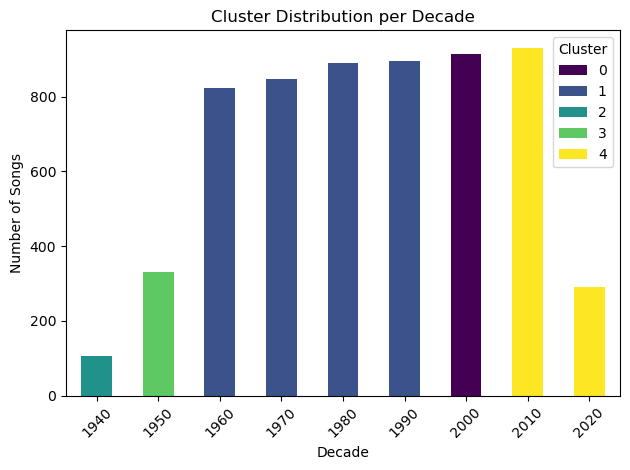

In [48]:
#plotting
plt.figure(figsize=(12, 8))
cluster_distribution.plot(kind='bar', stacked=True, colormap='viridis')
plt.xlabel('Decade')
plt.ylabel('Number of Songs')
plt.title('Cluster Distribution per Decade')
plt.legend(title='Cluster')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

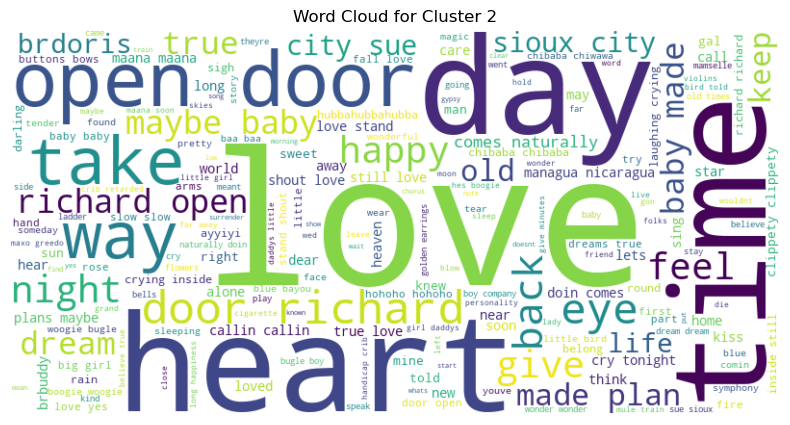

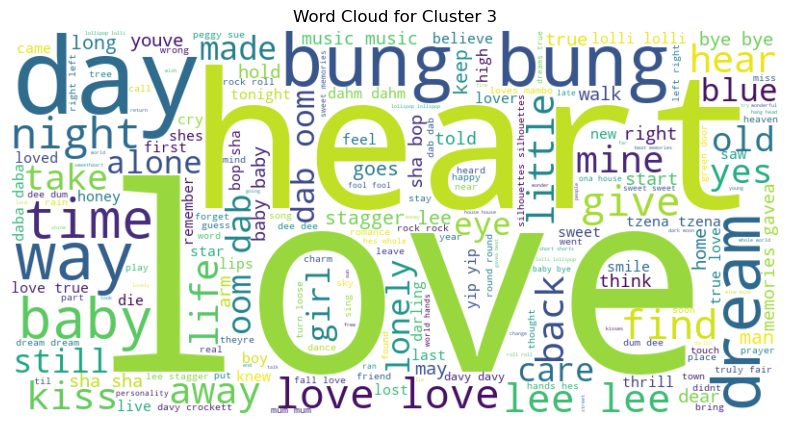

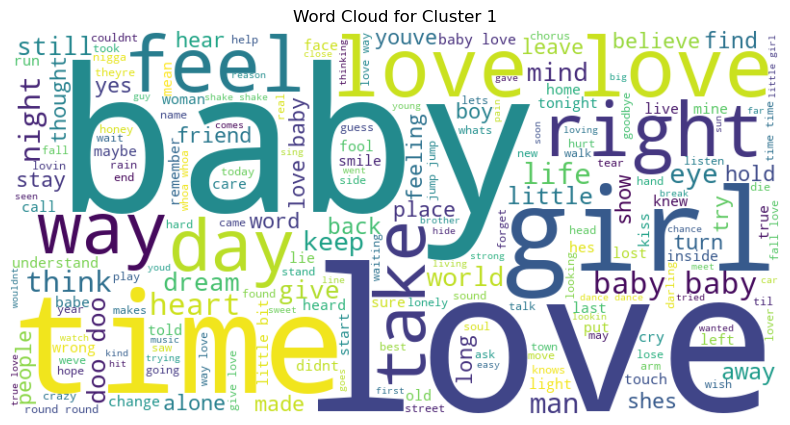

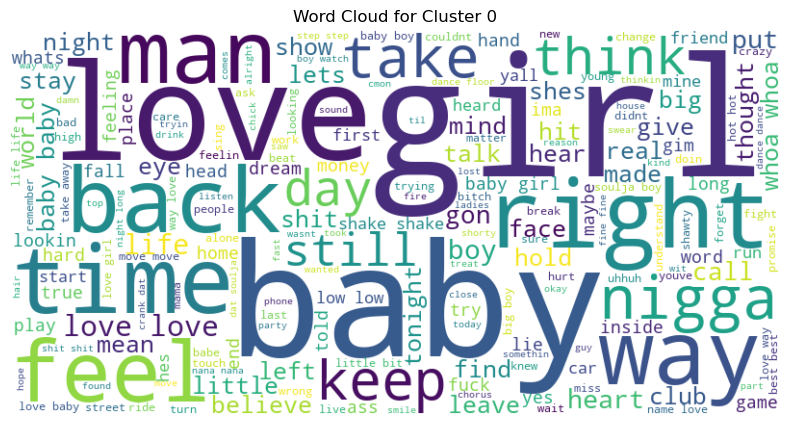

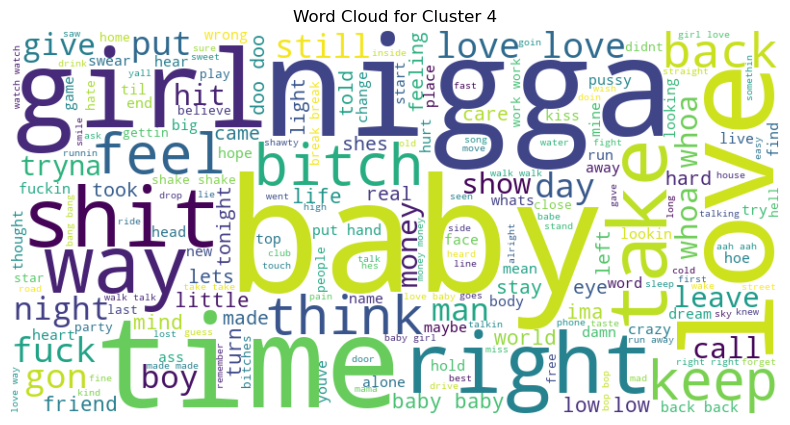

In [49]:
# Function to generate word cloud for each cluster
def generate_word_clouds(data, cluster_column='cluster', text_column='processed'):
    # Iterate over each cluster
    for cluster_id in data[cluster_column].unique():
        # Extract lyrics for the current cluster
        cluster_lyrics = data[data[cluster_column] == cluster_id][text_column].str.cat(sep=' ')

        # Generate word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_lyrics)

        # Plot word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Word Cloud for Cluster {cluster_id}')
        plt.axis('off')
        plt.show()

data_with_clusters["cleaned"]= data_with_clusters['lyrics'].apply(preprocess_text)
data_with_clusters['cleaned']= data_with_clusters['cleaned'].apply(remove_stopwords)
data_with_clusters['tokenized'] = data_with_clusters['cleaned'].apply(word_tokenize)
data_with_clusters['processed'] = data_with_clusters['tokenized'].apply(lambda x: " ".join(x))

data_with_clusters.head()

generate_word_clouds(data_with_clusters)

In [50]:
#importing foul words
profane_words_file = "foulwords.txt"
with open(profane_words_file, "r") as file:
    profane_words = file.read().splitlines()

In [51]:
data.head()
# Function to count profanity in lyrics for each decade
def count_profanity(decade):
    lyrics = decadal_lyrics[decadal_lyrics['decade'] == decade]['processed'].str.cat(sep=' ')
    tokens = word_tokenize(lyrics)
    count = sum(1 for token in tokens if token in profane_words)
    print(count)
    return count

# Calculate profanity count for each decade
decades = sorted(decadal_lyrics['decade'].unique())
profanity_counts = [count_profanity(decade) for decade in decades]




12
9
21
60
77
1106
2803
3978
1548


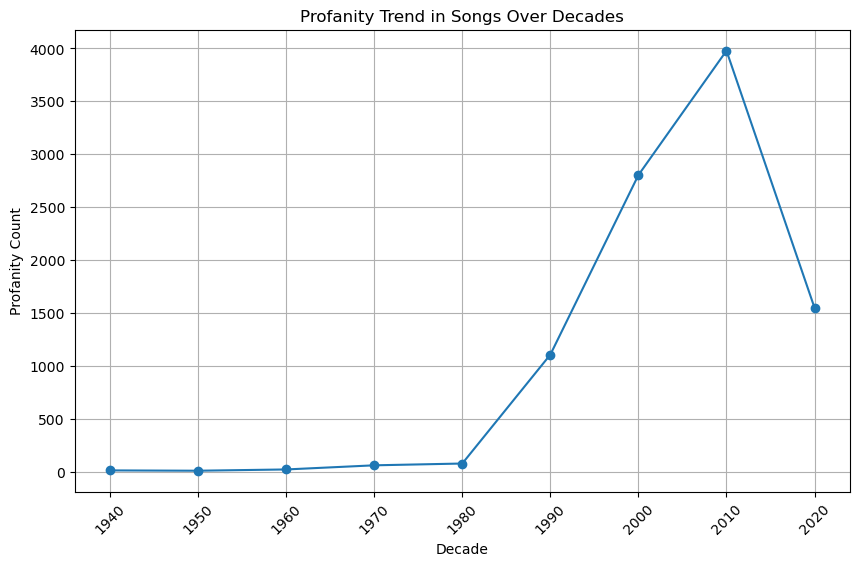

In [52]:
# Visualize profanity trend over the decades
plt.figure(figsize=(10, 6))
plt.plot(decades, profanity_counts, marker='o')
plt.title('Profanity Trend in Songs Over Decades')
plt.xlabel('Decade')
plt.ylabel('Profanity Count')
plt.xticks(decades, rotation=45)
plt.grid(True)
plt.show()